## Setting up the environment

To install the packages necessary to run this release notebook, run the following in the terminal. You will need to first access this folder using the terminal. 


conda create -n plso python=3.9

conda activate plso

pip install -r requirements.txt


You will need to run conda activate plso in the terminal before each time you launch this jupyter notebook. 

In [39]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizer
from torch.utils.data import WeightedRandomSampler 
import torch.nn as nn
from transformers import BertModel
from transformers import AdamW, get_linear_schedule_with_warmup

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch.nn.functional as F
import time

import calibration_fns as cal

from sklearn.metrics import accuracy_score, precision_score, recall_score, balanced_accuracy_score, f1_score

In [40]:
cwd = os.getcwd()
data_folder = cwd + '/Data_External/'

### Step 1. Set up dataset for pytorch

In [41]:
pd.set_option('display.max_colwidth', None)

In [42]:
### New
data_sources = pd.read_excel(data_folder + 'sources.xlsx')
data_more_better = pd.read_excel(data_folder + 'more_better.xlsx')
data_generic = pd.read_excel(data_folder + 'generic.xlsx')

#make 4 different classifiers

In [43]:
data_sources["P"] = (data_sources["code"] == "P").astype(int)
data_sources["L"] = (data_sources["code"] == "L").astype(int)
data_sources["S"] = (data_sources["code"] == "S").astype(int)
data_sources["O"] = (data_sources["code"] == "O").astype(int)

data_more = data_more_better[["ResponseId","Experiment","P_more","L_more","S_more","More_response","More_explanation"]]
data_better = data_more_better[["ResponseId","Experiment","P_better","L_better","S_better","Better_response","Better_explanation"]]

data_more.loc[:,"P"] = data_more["P_more"]
data_more.loc[:,"L"] = data_more["L_more"]
data_more.loc[:,"S"] = data_more["S_more"]
data_more.loc[:,"O"] = ((data_more["P"] == 0) & (data_more["L"] == 0) & (data_more["S"] == 0)).astype(int)

data_better.loc[:,"P"] = data_better["P_better"]
data_better.loc[:,"L"] = data_better["L_better"]
data_better.loc[:,"S"] = data_better["S_better"]
data_better.loc[:,"O"] = ((data_better["P"] == 0) & (data_more["L"] == 0) & (data_more["S"] == 0)).astype(int)

data_classical = data_generic[["DataSource","ResponseId","Response_Generic_Classical","CQ","code","n"]]
data_quantum = data_generic[["DataSource","ResponseId","Response_Generic_Quantum","CQ","code","n"]]

/tmp/ipykernel_1362734/368280069.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_more.loc[:,"P"] = data_more["P_more"]
/tmp/ipykernel_1362734/368280069.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_more.loc[:,"L"] = data_more["L_more"]
/tmp/ipykernel_1362734/368280069.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [44]:
data_classical = data_classical[data_classical["CQ"] == "C"]
data_quantum = data_quantum[data_quantum["CQ"] == "Q"]

data_classical["P"] = (data_classical["code"] == "P").astype(int)
data_classical["L"] = (data_classical["code"] == "L").astype(int)
data_classical["S"] = (data_classical["code"] == "S").astype(int)
data_classical["O"] = (data_classical["code"] == "O").astype(int)

data_quantum["P"] = (data_quantum["code"] == "P").astype(int)
data_quantum["L"] = (data_quantum["code"] == "L").astype(int)
data_quantum["S"] = (data_quantum["code"] == "S").astype(int)
data_quantum["O"] = (data_quantum["code"] == "O").astype(int)

#for responseid in data_classical[data_classical["n"] > 1]["ResponseId"].unique().tolist(): # get all the ResponseIds with multiple segments
    #print(data_classical[data_classical["ResponseId"] == responseid])

data_classical = data_classical.groupby("ResponseId", as_index=False).agg({
    'DataSource': 'first',
    'Response_Generic_Classical': 'first',
    'CQ': 'first',
    'n': 'max',
    'P': 'max',
    'L': 'max',
    'S': 'max',
    'O': 'max'
})

data_quantum = data_quantum.groupby("ResponseId", as_index=False).agg({
    'DataSource': 'first',
    'Response_Generic_Quantum': 'first',
    'CQ': 'first',
    'n': 'max',
    'P': 'max',
    'L': 'max',
    'S': 'max',
    'O': 'max'
})

#data_classical[data_classical["ResponseId"] == "R_2Vx7PHIwsvICNoB"]
#data_classical[data_classical["ResponseId"] == "R_1JCQsbN3AZRJs8w"]
    

In [47]:
data_quantum

,ResponseId,DataSource,Response_Generic_Quantum,CQ,n,P,L,S,O
0,R_12hjjdpHy2Crp9f,Cornell,uhm... actually I know about that experiment and also know that the result should be represented in only two ways... So I just felt the same way as in classical one sry :(,Q,1.0,0,1,0,0
1,R_1C7Mw9nkTGnZ5Ec,MSU,the uncertainty that arises from being unable to simultaneously know the properties of any two non-commuting operators like position and momentum,Q,1.0,1,0,0,0
2,R_1CjfD5GiIGLb1Ou,Cornell,"in systems looking at spin like before, this is the same as above, since by looking only at the positive height measurements we only consider the particles with spin +1/2 e.g. so variation is the same as above.\n\nhowever, measuring things more closely related to a wavefunction leads to uncertainty just by the probability of measuring the various amplitudes, whose specifics are lost on measurement",Q,3.0,1,1,0,0
3,R_1CmcDLwdJqttJwt,Boulder,built in uncertainty/randomness,Q,1.0,1,0,0,0
4,R_1Cr6XOv7xEp2ZA5,Cornell,the measurement uncertainty may be reduced but not eliminated.,Q,1.0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
139,R_sv8WLyY2hRH9xZv,MSU,"In quantum mechanics I think about measurement error as well, but with the additional lower bound caused by quantum effects, particularly the uncertainty principle. From quantum mechanics we know that there is no exact measurements to be made even in principle. So in a perfect world with no physical limitations on our measurements (e.g. unaccounted heat loss, etc.), the best we can do is only a statistical distribution.",Q,2.0,1,0,0,1
140,R_xDVqGLTXOGx3y93,Cornell,A fundamental part of working with quantum objects.,Q,1.0,1,0,0,0
141,R_xbUxVuNPfGX6VcB,Cornell,"Errors that are inherent in the act of measuring, regardless of what device is being used to do that measurement\n",Q,1.0,0,0,0,1
142,R_yHZc3rNv9Z0NTgt,Fullerton pilot,I think of a range of values that are possible.,Q,1.0,0,0,0,1


In [45]:
#train, val, test= du.getData(dataDir=dataDir, holdoutDir=holdoutDir,ValCutoff=ValCutoff)
data = pd.read_excel(data_folder + 'sources.xlsx')

def split_train_base_target(data):
    data = data.sample(frac=1).reset_index(drop=True)
    
    data["Response"] = data["Response"].astype(str)
    data["code"] = data["code"].astype(str)
    
    train_size = int(0.7*len(data))
    val_size = int(0.15*len(data))
    train_data = data[:train_size]
    base_data = data[train_size:train_size + val_size]
    target_data = data[train_size + val_size:]

In [46]:
len(train_data)

NameError: name 'train_data' is not defined

In [6]:
def get_max_len(tokenizer, train):
    all_sent = np.array(train.Response.values)
    # Encode data
    encoded_sentences = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_sent]
    # Find the maximum length
    max_len = max([len(sent) for sent in encoded_sentences])
    return max_len

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
MAX_LEN = get_max_len(tokenizer, train_data) 

In [8]:
print(MAX_LEN)

101


In [9]:
def text_preprocessing_simple(text):
    try:
        text = re.sub(r'\s+', ' ', text).strip()
    except:
        pass
    return text

In [10]:
def preprocessing_for_bert(data, tokenizer, max_len):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing_simple(str(sent)),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=max_len,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [11]:
class SourcesDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.data, self.masks = preprocessing_for_bert(df["Response"], tokenizer, MAX_LEN)
        self.text = df["Response"].reset_index(drop=True)
        labels_enc, unique_labels = pd.factorize(df["code"], sort = True)
        self.labels = torch.tensor(labels_enc, dtype = torch.long)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        sample = self.data[idx]
        mask = self.masks[idx]
        label = self.labels[idx]
        return sample, mask, label

In [12]:
labels_enc, unique_labels = pd.factorize(train_data["code"], sort = True)
target_to_class = {i:unique_labels[i] for i in range(len(unique_labels))}

In [13]:
target_to_class

{0: 'L', 1: 'O', 2: 'P', 3: 'S'}

In [14]:
train_dataset = SourcesDataset(train_data, tokenizer, MAX_LEN)
base_dataset = SourcesDataset(base_data, tokenizer, MAX_LEN)
target_dataset = SourcesDataset(target_data, tokenizer, MAX_LEN)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/rkf33/.conda/envs/labnotes7/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2829: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/rkf33/.conda/envs/labnotes7/lib/python3.12/site-packages/transformers/

In [15]:
len(train_dataset)

2029

In [16]:
train_dataset[2]

(tensor([  101, 15012,  2013, 13276,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0]),
 tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 

In [17]:
for data, mask, label in train_dataset:
    break

In [18]:
class_counts = train_data.code.value_counts()

In [19]:
#sample_weights = [1.0 / class_counts[i] for i in train_data.code.values]
class_weights = 1.0 / class_counts
class_weights[1] = class_weights[1] / 4 # underweight "other"
sample_weights = [class_weights[i] for i in train_data.code.values]
class_weights = torch.tensor(class_weights, dtype=torch.float)

train_sampler=WeightedRandomSampler(sample_weights,len(train_dataset), replacement=True)

train_dataloader = DataLoader(train_dataset, batch_size = 16, sampler = train_sampler)
base_dataloader = DataLoader(base_dataset, batch_size = 16) 
target_dataloader = DataLoader(target_dataset, batch_size = 16) 

/tmp/ipykernel_3139363/3474696145.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  class_weights[1] = class_weights[1] / 4 # underweight "other"
/tmp/ipykernel_3139363/3474696145.py:3: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  class_weights[1] = class_weights[1] / 4 # underweight "other"
/tmp/ipykernel_3139363/3474696145.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  class_weights = torch.tensor(class_weights, dtype

In [20]:
class_counts

code
L    1570
O     284
P     111
S      64
Name: count, dtype: int64

In [21]:
for sents, masks, labels in train_dataloader:
    break

In [22]:
sents.shape
masks.shape
labels

tensor([2, 0, 3, 0, 2, 2, 3, 0, 3, 0, 2, 0, 2, 3, 3, 2])

### Step 2. Set up Pytorch Model

In [23]:
class SourcesClassifier(nn.Module):
    def __init__(self, num_classes=4, freeze_bert = False):
        #Where we define all the parts of the model
        super(SourcesClassifier, self).__init__()  # initialize object with everything from the parent class
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 200, num_classes
        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )
        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
    def forward(self, input_ids, attention_mask):
        # Connect these parts and return the output
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]
        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)
        return logits

In [24]:
model = SourcesClassifier(num_classes = 4)
print(model)

SourcesClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [25]:
example_out = model(sents, masks)

In [26]:
example_out.shape #batch size, num_classes

torch.Size([16, 4])

In [27]:
example_out

tensor([[ 0.2423, -0.0391,  0.0628,  0.0117],
        [ 0.1215, -0.1151, -0.0008, -0.0908],
        [ 0.1203, -0.0809,  0.0683, -0.0172],
        [ 0.1537, -0.0800,  0.0747, -0.1614],
        [ 0.1920, -0.0484,  0.0766, -0.0787],
        [ 0.2571, -0.0159, -0.0162,  0.0277],
        [ 0.1627, -0.0740,  0.1029, -0.1443],
        [ 0.0839, -0.0404, -0.0008, -0.0653],
        [ 0.2437, -0.0062,  0.0722, -0.0512],
        [ 0.1725, -0.0597,  0.1042, -0.1212],
        [ 0.1892, -0.0389,  0.0898, -0.1127],
        [ 0.0843, -0.1356,  0.1315, -0.1160],
        [ 0.1616, -0.0084,  0.1277, -0.0640],
        [ 0.1412, -0.0417,  0.0428, -0.1067],
        [ 0.1203, -0.0809,  0.0683, -0.0172],
        [ 0.1437, -0.0436,  0.0606, -0.1531]], grad_fn=<AddmmBackward0>)

### Step 3. The training loop

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available()  else "cpu")
print(device)

cpu


In [29]:
# Loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [30]:
criterion(example_out, labels) # check that the loss function calculates. It won't be any good yet because we haven't done training

tensor(1.4329, grad_fn=<NllLossBackward0>)

In [31]:
labels

tensor([2, 0, 3, 0, 2, 2, 3, 0, 3, 0, 2, 0, 2, 3, 3, 2])

In [32]:
for param in model.bert.pooler.parameters():
    param.requires_grad = True

In [33]:
for module in model.modules():
    if isinstance(module, torch.nn.LayerNorm):
        module.eval()  # Set LayerNorm to eval mode

In [34]:
num_epochs = 7
train_losses, val_losses = [], []


model = SourcesClassifier(num_classes=4)
model.to(device)

total_steps = len(train_dataloader) * num_epochs # Total number of training steps

optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay = 1e-5)

scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))


for epoch in range(num_epochs):
    print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*70)
    running_loss = 0.0
    t0_epoch, t0_batch = time.time(), time.time()
    total_loss, batch_loss, batch_counts = 0, 0, 0 # Reset tracking variables at the beginning of each epoch
    model.train() # Set the model to train
    for batch_idx, (sents, masks, labels) in enumerate(train_dataloader): 
        batch_counts +=1
        sents, masks, labels = sents.to(device), masks.to(device), labels.to(device)
        optimizer.zero_grad() # set our optimizer to zero_grad
        outputs = model(sents, masks) # get our outputs by calling the forward method on the images
        loss = loss_fn(outputs, labels)
        loss.backward() # this is where we do backpropagation on the model to update the model weights
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) 
        optimizer.step()
        scheduler.step()
        #print(f"Batch {batch_idx}: Loss = {loss.item()}")
        batch_loss += loss.item()
        running_loss += loss.item() * sents.size(0)
        # Print the loss values and time elapsed for every 20 batches
        if (batch_idx % 20 == 0 and batch_idx != 0) or (batch_idx == len(train_dataloader) - 1):
            # Calculate time elapsed for 20 batches
            time_elapsed = time.time() - t0_batch
            # Print training results
            print(f"{epoch + 1:^7} | {batch_idx:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")
    batch_loss, batch_counts = 0, 0
    t0_batch = time.time()
    train_loss = running_loss / len(train_dataloader.dataset)
    train_losses.append(train_loss)
    print("-"*70)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    val_accuracy = []
    with torch.no_grad(): #to make sure the model weights are not touched
        for sents, masks, labels in base_dataloader:
            sents, masks, labels = sents.to(device), masks.to(device), labels.to(device)
            outputs = model(sents, masks)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item() * sents.size(0)
            # Get the predictions
            preds = torch.argmax(outputs, dim=1).flatten()
            # Calculate the accuracy rate
            accuracy = (preds == labels).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)
            time_elapsed = time.time() - t0_epoch
    val_loss = running_loss / len(base_dataloader.dataset)
    val_losses.append(val_loss)
    val_accuracy = np.mean(val_accuracy)

    #Print epoch stats
    print(f"{epoch+1:^7} | {'-':^7} | {train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


KeyboardInterrupt: 

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [54]:
model.eval()
model=model.to(device)
all_logits = []
all_labels = []
# For each batch in our test set...
for sents, masks, labels in base_dataloader:
    sents, masks = sents.to(device), masks.to(device)
    # Compute logits
    with torch.no_grad():
        logits = model(sents, masks)
        all_logits.append(logits)
        all_labels.append(labels)
# Concatenate logits from each batch
all_logits = torch.cat(all_logits, dim=0)
all_labels = torch.cat(all_labels, dim = 0).cpu().numpy()
# Apply softmax to calculate probabilities
probs = F.softmax(all_logits, dim=1).cpu().numpy()
preds = torch.argmax(all_logits, dim=1).flatten().cpu().numpy()
all_logits = all_logits.cpu().numpy()

In [55]:
preds_LOPS = list(pd.Series(preds).map(target_to_class))
print("L: " + str(preds_LOPS.count("L")))
print("P: " + str(preds_LOPS.count("P")))
print("S: " + str(preds_LOPS.count("S")))
print("O: " + str(preds_LOPS.count("O")))

L: 332
P: 31
S: 21
O: 50


In [56]:
# calculate metrics

acc = accuracy_score(all_labels, preds)
p = precision_score(all_labels, preds, average = None)
r = recall_score(all_labels, preds, average = None)
bal = balanced_accuracy_score(all_labels,preds)
f1 = f1_score(all_labels,preds, average = None)

print(acc)
print(p)
print(r)
print(bal)
print(f1)

0.8847926267281107
[0.92168675 0.72       0.77419355 0.85714286]
[0.93865031 0.61016949 0.82758621 0.9       ]
0.8191015012926104
[0.93009119 0.66055046 0.8        0.87804878]


In [57]:
#calibration phase: calculate a calibration curve. along with a base classifier density, we can get the base joint density and estimate the base prevalence

print("Base dataset: number of samples in each category")
base_labels =list(pd.Series(base_dataset.labels.numpy()).map(target_to_class))
print("L: " + str(base_labels.count("L")))
print("P: " + str(base_labels.count("P")))
print("S: " + str(base_labels.count("S")))
print("O: " + str(base_labels.count("O")))

Base dataset: number of samples in each category
L: 326
P: 29
S: 20
O: 59


In [58]:
#all_logits
#probs = F.softmax(all_logits, dim=1).cpu().numpy()

In [60]:
df = pd.DataFrame(data = {"probs_L": probs[:,0], "probs_O": probs[:,1], "probs_P": probs[:,2], "probs_S": probs[:,3], "gt_label":list(pd.Series(all_labels).map(target_to_class)), "text":list(base_dataset.text.values)})

In [61]:
df

,probs_L,probs_O,probs_P,probs_S,gt_label,text
0,0.937489,0.041414,0.013304,0.007793,L,Human Error
1,0.938768,0.037710,0.014751,0.008771,L,Students may have estimated differently where ...
2,0.928007,0.050728,0.013976,0.007289,L,Minor differences in the height of the tables
3,0.162928,0.802146,0.008031,0.026895,L,I assume the height of the tables are the same...
4,0.549672,0.426660,0.009655,0.014013,L,testing errors
...,...,...,...,...,...,...
429,0.001581,0.006180,0.001614,0.990625,S,Statistical fluctuations in measurement
430,0.938404,0.042833,0.011952,0.006811,L,uncertainty in measurement of x (where exactly...
431,0.940604,0.036980,0.014427,0.007989,L,Uncertainties in the initial velocity of the ball
432,0.001053,0.001630,0.001422,0.995894,S,Poisson


In [62]:
df["probs_L"]

0      0.937489
1      0.938768
2      0.928007
3      0.162928
4      0.549672
         ...   
429    0.001581
430    0.938404
431    0.940604
432    0.001053
433    0.260124
Name: probs_L, Length: 434, dtype: float32

(array([ 55.,   9.,   8.,   3.,   4.,   3.,   6.,   4.,   4.,   6.,   3.,
          9.,   4.,   2.,   7.,   7.,  11.,  11.,  25., 253.]),
 array([9.40587255e-04, 4.80017252e-02, 9.50628594e-02, 1.42123997e-01,
        1.89185143e-01, 2.36246288e-01, 2.83307403e-01, 3.30368549e-01,
        3.77429694e-01, 4.24490839e-01, 4.71551985e-01, 5.18613100e-01,
        5.65674186e-01, 6.12735331e-01, 6.59796476e-01, 7.06857622e-01,
        7.53918767e-01, 8.00979912e-01, 8.48041058e-01, 8.95102203e-01,
        9.42163348e-01]),
 <BarContainer object of 20 artists>)

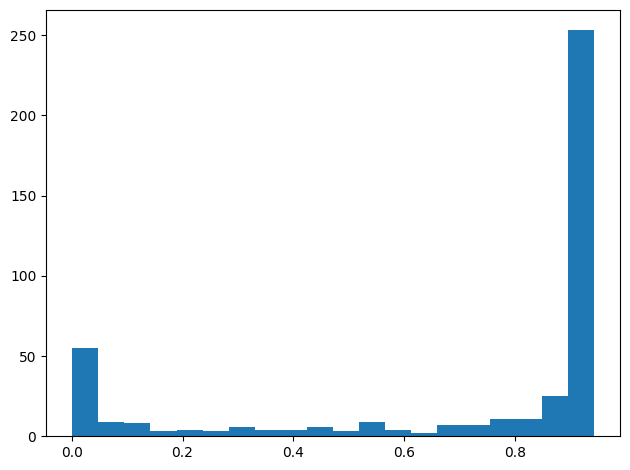

In [63]:
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
axs.hist(df["probs_L"], bins = 20)

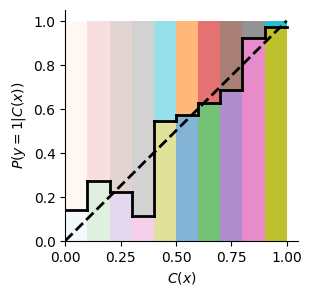

In [64]:
binned_cal_curve = cal.generate_calibration_curve_binned(df, num_bin = 10, code = "L", other_codes = ["O","P","S"])
binned_cal_curve.plot(show_diagonal=True)

In [67]:
df = pd.DataFrame(data = {"probs_L": probs[:,0], "probs_O": probs[:,1], "probs_P": probs[:,2], "probs_S": probs[:,3], "gt_label":list(pd.Series(all_labels).map(target_to_class)), "text":list(base_dataset.text.values)})

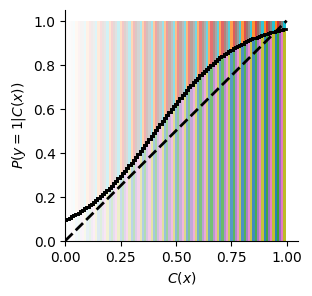

In [68]:
platt_cal_curve = cal.generate_calibration_curve_platt(df, code = "L", other_codes = ["O","P","S"])
platt_cal_curve.plot(show_diagonal=True, error_score = "raise")

In [69]:
# extrapolation phase: run probabilistic estimator

In [70]:
model.eval()
model=model.to(device)
all_logits = []
all_labels = []
# For each batch in our test set...
for sents, masks, labels in target_dataloader:
    sents, masks = sents.to(device), masks.to(device)
    # Compute logits
    with torch.no_grad():
        logits = model(sents, masks)
        all_logits.append(logits)
        all_labels.append(labels)
# Concatenate logits from each batch
all_logits = torch.cat(all_logits, dim=0)
all_labels = torch.cat(all_labels, dim = 0)
# Apply softmax to calculate probabilities
probs = F.softmax(all_logits, dim=1).cpu().numpy()
preds = torch.argmax(all_logits, dim=1).flatten()


In [71]:
df = pd.DataFrame(data = {"probs_L": probs[:,0], "probs_O": probs[:,1], "probs_P": probs[:,2], "probs_S": probs[:,3], "gt_label":list(pd.Series(all_labels.cpu().numpy()).map(target_to_class)), "text":list(target_dataset.text.values)})

## Calibration curves for L

(array([ 45.,  19.,  14.,   1.,   2.,   7.,   2.,   7.,   3.,   6.,   3.,
          4.,   5.,   3.,   4.,   6.,  10.,  13.,  26., 256.]),
 array([9.36491298e-04, 4.79883291e-02, 9.50401723e-02, 1.42092004e-01,
        1.89143851e-01, 2.36195698e-01, 2.83247501e-01, 3.30299348e-01,
        3.77351195e-01, 4.24403042e-01, 4.71454889e-01, 5.18506765e-01,
        5.65558553e-01, 6.12610400e-01, 6.59662247e-01, 7.06714094e-01,
        7.53765941e-01, 8.00817788e-01, 8.47869635e-01, 8.94921482e-01,
        9.41973269e-01]),
 <BarContainer object of 20 artists>)

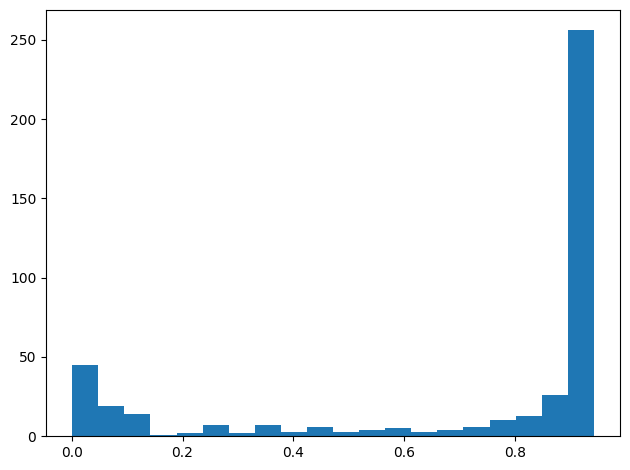

In [72]:
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
axs.hist(df["probs_L"], bins = 20)

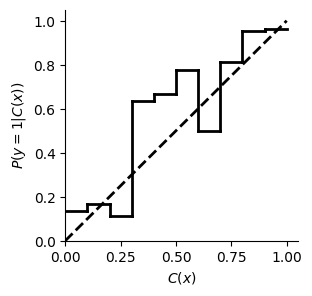

In [73]:
df = pd.DataFrame(data = {"probs_L": probs[:,0], "probs_O": probs[:,1], "probs_P": probs[:,2], "probs_S": probs[:,3], "gt_label":list(pd.Series(all_labels.cpu().numpy()).map(target_to_class)), "text":list(target_dataset.text.values)})
binned_cal_curve = cal.generate_calibration_curve_binned(df, num_bin = 10, code = "L", other_codes = ["O","P","S"])
binned_cal_curve.plot(show_diagonal=True, filled = False)

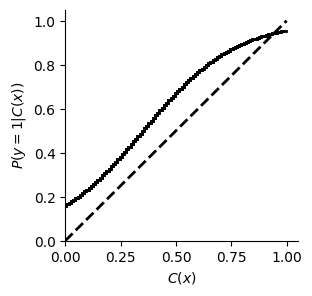

In [76]:
df = pd.DataFrame(data = {"probs_L": probs[:,0], "probs_O": probs[:,1], "probs_P": probs[:,2], "probs_S": probs[:,3], "gt_label":list(pd.Series(all_labels.cpu().numpy()).map(target_to_class)), "text":list(target_dataset.text.values)})
platt_cal_curve = cal.generate_calibration_curve_platt(df, code = "L", other_codes = ["O","P","S"])
platt_cal_curve.plot(show_diagonal=True, filled = False)
plt.savefig("cal_curve.png")
plt.savefig("cal_curve.pdf")

In [52]:
est_prevalence = cal.extrinsic_estimate(df, platt_cal_curve, code = "L")
print(f'Assuming stable calibration curve -- estimated prevalence: {est_prevalence:.3f}')

Assuming stable calibration curve -- estimated prevalence: 0.773


In [53]:
print("Target dataset: number of samples in each category")
target_labels =list(pd.Series(target_dataset.labels.numpy()).map(target_to_class))
print("L: " + str(base_labels.count("L")))
print("P: " + str(base_labels.count("P")))
print("S: " + str(base_labels.count("S")))
print("O: " + str(base_labels.count("O")))

Target dataset: number of samples in each category
L: 332
P: 23
S: 22
O: 57


In [54]:
328/(328+27+11+68)

0.7557603686635944

In [55]:
list(preds.cpu().numpy()).count(0)/len(preds)

0.7637614678899083

In [56]:
display_data = pd.DataFrame(data = {"preds":list(pd.Series(preds.cpu().numpy()).map(target_to_class)), "labels":list(pd.Series(all_labels.cpu().numpy()).map(target_to_class)), "text":list(target_dataset.text.values)})

In [57]:
pd.set_option('display.max_colwidth', None)
display_data[20:30]

,preds,labels,text
20,L,L,Slipping on the ramp.
21,L,L,Accidentally giving the ball an initial velocity
22,L,L,uncertainty in initial height and direction of the particle
23,L,L,Differences in distribution of particles in water between students
24,S,S,Looks like a decent Gaussian distribution due to random uncertainties in the measurements
25,L,O,Uncerainty
26,L,L,the initial velocity
27,L,L,a ruler is not a suitably-precise instrument for this task
28,L,L,Differences in drag
29,L,O,Error in measurement of time and distance


## Calibration curves for P

(array([407.,   2.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   2.,   0.,   1.,   2.,   0.,  19.]),
 array([4.27562743e-04, 5.02071753e-02, 9.99867916e-02, 1.49766400e-01,
        1.99546009e-01, 2.49325618e-01, 2.99105257e-01, 3.48884851e-01,
        3.98664474e-01, 4.48444098e-01, 4.98223692e-01, 5.48003256e-01,
        5.97782910e-01, 6.47562504e-01, 6.97342098e-01, 7.47121751e-01,
        7.96901345e-01, 8.46680939e-01, 8.96460593e-01, 9.46240187e-01,
        9.96019781e-01]),
 <BarContainer object of 20 artists>)

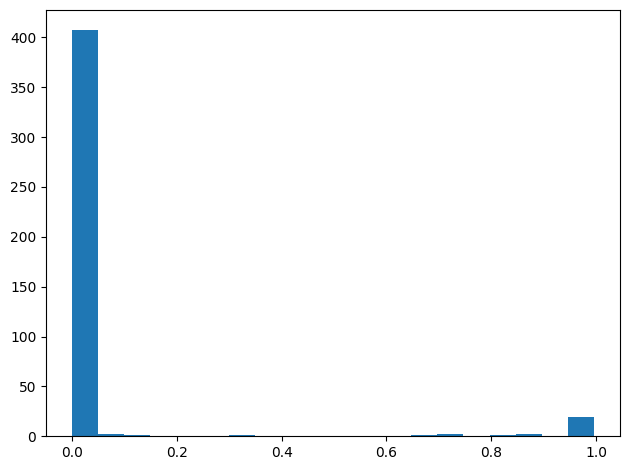

In [58]:
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
axs.hist(df["probs_P"], bins = 20)

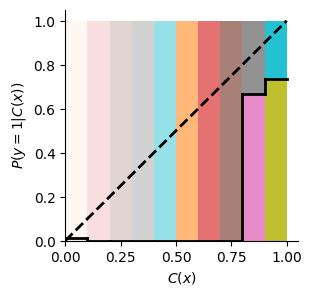

In [59]:
df = pd.DataFrame(data = {"probs_L": probs[:,0], "probs_O": probs[:,1], "probs_P": probs[:,2], "probs_S": probs[:,3], "gt_label":list(pd.Series(all_labels.cpu().numpy()).map(target_to_class)), "text":list(target_dataset.text.values)})
binned_cal_curve = cal.generate_calibration_curve_binned(df, num_bin = 10, code = "P", other_codes = ["O","L","S"])
binned_cal_curve.plot(show_diagonal=True)

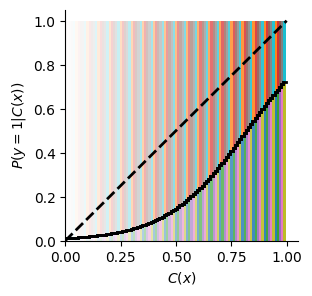

In [60]:
df = pd.DataFrame(data = {"probs_L": probs[:,0], "probs_O": probs[:,1], "probs_P": probs[:,2], "probs_S": probs[:,3], "gt_label":list(pd.Series(all_labels.cpu().numpy()).map(target_to_class)), "text":list(target_dataset.text.values)})
platt_cal_curve = cal.generate_calibration_curve_platt(df, code = "P", other_codes = ["O","L","S"])
platt_cal_curve.plot(show_diagonal=True)

In [61]:
est_prevalence = cal.extrinsic_estimate(df, platt_cal_curve, code = "P")
print(f'Assuming stable calibration curve -- estimated prevalence: {est_prevalence:.3f}')

Assuming stable calibration curve -- estimated prevalence: 0.048


## Calibration curves for S

(array([412.,   2.,   2.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,  16.]),
 array([0.00103713, 0.05088137, 0.10072561, 0.15056986, 0.20041409,
        0.25025833, 0.30010256, 0.3499468 , 0.39979103, 0.44963527,
        0.4994795 , 0.54932374, 0.599168  , 0.64901221, 0.69885647,
        0.74870068, 0.79854494, 0.84838921, 0.89823341, 0.94807768,
        0.99792188]),
 <BarContainer object of 20 artists>)

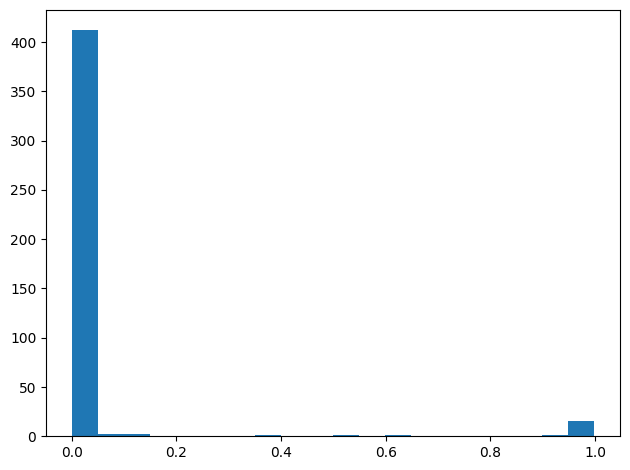

In [62]:
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
axs.hist(df["probs_S"], bins = 20)

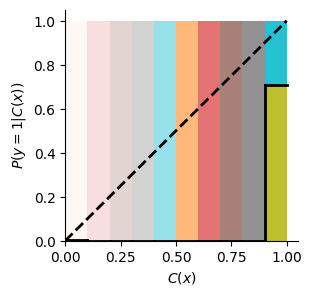

In [63]:
df = pd.DataFrame(data = {"probs_L": probs[:,0], "probs_O": probs[:,1], "probs_P": probs[:,2], "probs_S": probs[:,3], "gt_label":list(pd.Series(all_labels.cpu().numpy()).map(target_to_class)), "text":list(target_dataset.text.values)})
binned_cal_curve = cal.generate_calibration_curve_binned(df, num_bin = 10, code = "S", other_codes = ["O","P","L"])
binned_cal_curve.plot(show_diagonal=True)

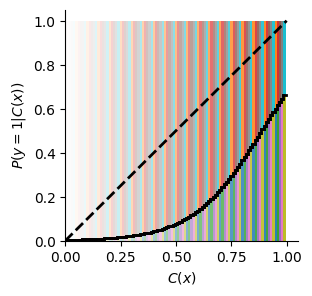

In [64]:
df = pd.DataFrame(data = {"probs_L": probs[:,0], "probs_O": probs[:,1], "probs_P": probs[:,2], "probs_S": probs[:,3], "gt_label":list(pd.Series(all_labels.cpu().numpy()).map(target_to_class)), "text":list(target_dataset.text.values)})
platt_cal_curve = cal.generate_calibration_curve_platt(df, code = "S", other_codes = ["O","P","L"])
platt_cal_curve.plot(show_diagonal=True)

In [65]:
est_prevalence = cal.extrinsic_estimate(df, platt_cal_curve, code = "S")
print(f'Assuming stable calibration curve -- estimated prevalence: {est_prevalence:.3f}')

Assuming stable calibration curve -- estimated prevalence: 0.030
